<a href="https://colab.research.google.com/github/JuliIglesias/Inteligencia-Artificial/blob/main/TP_1_Base_Bernardez%2C_Iglesias%2C_Rickert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

!ls

data_description.txt  sample_data  sample_submission.csv  test.csv  train.csv


## Procesamiento de data


In [ ]:
train = pd.read_csv("train.csv")
print("train : " + str(train.shape))

# Check for duplicates
uniqueIds = len(set(train.Id))
totalIds = train.shape[0]
duplicateIds = totalIds - uniqueIds
print("There are " + str(duplicateIds) + " duplicate IDs for " + str(totalIds) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)

train.describe()



train : (1460, 81)
There are 0 duplicate IDs for 1460 total entries


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


La variable que nos importa predecir es `SalePrice`.
Nuestro trabajo entonces es encontrar el feature set para todas estas variables

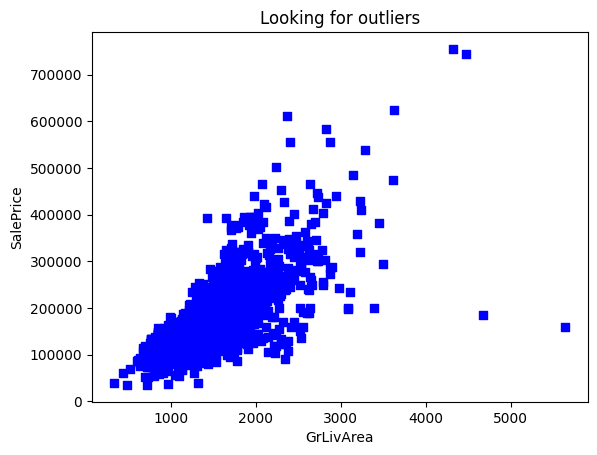

In [ ]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

## Transformaciones y preparacion de la informacion

Lo primero que hacemos es aplicar transformar el precio por su logaritmo natural mas uno `log(x + 1)`.

De esta manera el efecto en el error de predecir precios extremos (muy baratos y muy caros) es el mismo sobre el resultado.

In [ ]:
# Log transform the target for official scoring
# Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

Ahora limpiamos la informacion: existen algunos valores que nos hacen mas complicado trabajar sobre la misma, como los NA, que es mas facil reemplazarlos con un 0 o un None o un No.

In [ ]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

Tambien existen algunos valores que son numericos que en realidad tienen que ser evaluados como categorias, como el mes en el que se vendio la casa y la subclase de la vivienda.

In [ ]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120",
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

Lo mismo sucede al reves: es mas comodo trabajar algunas categorias como valores numericos, especialmente cuando hay valor en los mismos: Po (Poor) es un valor malo para una categoria, por lo que le vamos a asignar el 0, mientras que a Ex (Excellent) le vamos a asignar un valor numerico mas alto (5, en comparacion)

In [ ]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Otra simplificacion que podemos hacer es establecer un espacio mas simple para valores que originalmente vienen con "mucha precision", la cual a nosotros no nos interesa. En vez de manejar un espacio de 10 valores posibles normalizamos todo en 3 o 2.
Entonces de una variable normal la transformamos en una variable simple.
Ademas hay algunas variable que estan muy relacionadas, como la calidad y la condicion de algun aspecto, como lo puede ser el material exterior. Entonces lo que hacemos es multiplicar ambas y obtener una columna que nos permite representar las dos combinadas: si la calidad y la condicion son buenas entonces el `Grade` va ser muy bueno. Si el material original es muy bueno pero su condicion es mala su `Grade` se va a ver degradado.

In [ ]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1,
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

Habiendo realizado estas transformaciones y generado nueva informacion nos interesa ahora hacer un analisis rapido de la correlacion entre nuestras variables, usando simplemente `corr` de Pandas.

Ademas ordenamos todas las filas de Corr en funcion al `SalePrice`

In [ ]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr(numeric_only=True)
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice         1.000000
OverallQual       0.819240
AllSF             0.817272
AllFlrsSF         0.729421
GrLivArea         0.718844
                    ...   
LandSlope        -0.040114
SimplExterCond   -0.042183
KitchenAbvGr     -0.147891
EnclosedPorch    -0.148636
LotShape         -0.285903
Name: SalePrice, Length: 88, dtype: float64


<ipython-input-10-be493b8a0e14>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


In [ ]:
print("Top 15 most important features")
print(corr.head(15).SalePrice)

Top 15 most important features
SalePrice           1.000000
OverallQual         0.819240
AllSF               0.817272
AllFlrsSF           0.729421
GrLivArea           0.718844
SimplOverallQual    0.707934
ExterQual           0.680947
GarageCars          0.680408
TotalBath           0.672929
KitchenQual         0.667174
GarageScore         0.656822
GarageArea          0.655212
TotalBsmtSF         0.641553
SimplExterQual      0.635550
SimplGarageScore    0.630802
Name: SalePrice, dtype: float64


In [ ]:
print("Top 15 least important features")
print(corr.tail(15).SalePrice)

Top 15 least important features
PoolQC              0.038255
BsmtFinType2        0.015652
Utilities           0.012618
BsmtFinSF2          0.006420
BsmtHalfBath       -0.014974
MiscVal            -0.019752
SimplOverallCond   -0.028044
YrSold             -0.034319
OverallCond        -0.036843
LowQualFinSF       -0.037698
LandSlope          -0.040114
SimplExterCond     -0.042183
KitchenAbvGr       -0.147891
EnclosedPorch      -0.148636
LotShape           -0.285903
Name: SalePrice, dtype: float64


In [ ]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [ ]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [ ]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


Ahora medimos la oblicuidad de los valores de todas las columnas numericas de nuestra data.

La funcion skew mide cuan lejos esta la informacion de tener una distribucion normal estandar. El valor se vuelve mas negativo conforme se concentra la masa del lado derecho y se vuelve mas positivo conforme se concentra la masa en lado izquierdo

A todas aquellas columnas que presentan alguna concentracion (mayor a 0.5 para cualquier lado) les aplicamos el logaritmo natural mas uno y las reemplazamos por este nuevo valor.

In [ ]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


In [ ]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


## Desarrollo

Una de las primeras cosas que tenemos que hacer es implementar un metodo que nos permite armar subsets de el dataframe `train`. En funcion a esto vamos a lograr tener un conjunto para training y otro para testing (en este caso lo llamamos validacion, porque en realidad tenemos un csv exclusivo para testing)

Implementamos entonces `train_test_data`, que recibe dos dataframes y nos devuelve una tupla de 4 arrays (x_train, x_test, y_train, y_test)

In [ ]:
def train_test_split_own(x , y,  test_size = 0.3, train_size = 0.7, random_state = None):
  if(test_size + train_size != 1):
    raise Exception("Invalid test and train size. It should sum 1")
  shuffled_x = x.sample(frac = 1, random_state = random_state)
  shuffled_y = y.sample(frac = 1, random_state = random_state)
  x_train = shuffled_x.head(int(len(shuffled_x)*(train_size)) + 1)
  y_train = shuffled_y.head(int(len(shuffled_y)*(train_size))+ 1)
  x_test = shuffled_x.tail(int(len(shuffled_x)*(test_size)))
  y_test = shuffled_y.tail(int(len(shuffled_y)*(test_size)))
  return (x_train, x_test, y_train, y_test)

Ejecutamos ahora esto con la data

In [ ]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split_own(train, y, test_size = 0.3, random_state =42)
print("X_train")
print(str(X_train))
print("X_test")
print(str(X_test))
print("y_train")
print(str(y_train))
print("y_test")
print(str(y_test))

New number of features : 319
X_train
      LotFrontage    LotArea    Street  LotShape  Utilities  LandSlope  \
497          60.0   9.118335  1.098612  1.609438   1.609438   1.386294   
1264         34.0   8.309185  1.098612  1.609438   1.609438   1.386294   
411         100.0  10.453082  1.098612  1.609438   1.609438   1.386294   
1048        100.0   9.987415  1.098612  1.609438   1.609438   1.386294   
1035          0.0   9.350189  1.098612  1.386294   1.609438   1.386294   
...           ...        ...       ...       ...        ...        ...   
971          36.0   7.727094  1.098612  1.609438   1.609438   1.386294   
923          50.0   8.988821  1.098612  1.609438   1.609438   1.386294   
605          85.0   9.517899  1.098612  1.609438   1.609438   1.386294   
1396          0.0  10.954327  1.098612  1.386294   1.609438   0.693147   
89           60.0   8.996033  1.098612  1.609438   1.609438   1.386294   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd  ...  SaleType_Con

Usamos un Standard Scaler para normalizar la informacion en funcion a sus numerical features

In [ ]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

## Trabajo propio

Lo primero que tenemos que hacer es implementar nuestras propias funciones de prediccion: LinearRegression, Lasso, Ridge y Elastic Net, y utilizarlos para desarrollar un modelo predictivo.




In [ ]:
model = lambda x,theta: np.dot(x,theta)

In [ ]:
def rmse(predicted_y, actual_y):
  return np.sqrt(np.sum(np.square(actual_y-predicted_y))/len(y))

### GLM
Implementamos nuestro propio GLM y obtenemos un modelo predecitivo a partir del mismo

In [ ]:
class GLMRegression:
    def __init__(self, hypothesis,step_size=0.00005, max_iter=100000, eps=1e-10,theta_0=None, verbose=True):
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.hypothesis = hypothesis
        self.theta_progress = []

    def fit(self, x, y):
        iternumber = 0
        if self.theta is None:
          self.theta = np.zeros(x.shape[1])

        while iternumber < self.max_iter:
            iternumber += 1

            predicted_probabilities = self.predict(x)

            error = predicted_probabilities -y

            gradient = np.dot(x.transpose(),error)

            if self.verbose:
                print("Iteration:" + str(iternumber)+' '+ "Sum of error:" + str(np.sum(error)))

            theta_old = self.theta
            self.theta_progress.append(self.theta)
            self.theta = self.theta - self.step_size * gradient
            if (abs(self.theta-theta_old) < self.eps).all():
                break

        return self.theta

    def predict(self, x):
      return self.hypothesis(x,self.theta)


#### Training

Entrenamos nuestro modelo de regresion lineal y obtenemos los pesos correspondientes

In [ ]:
glm = GLMRegression(model,step_size=0.00005,max_iter=10000)
glm.fit(X_train,y_train)

Streaming output truncated to the last 5000 lines.
Iteration:5001 Sum of error:-0.995065319601899
Iteration:5002 Sum of error:-0.9948372763331808
Iteration:5003 Sum of error:-0.9946093182882318
Iteration:5004 Sum of error:-0.99438144541163
Iteration:5005 Sum of error:-0.9941536576681447
Iteration:5006 Sum of error:-0.9939259549976374
Iteration:5007 Sum of error:-0.9936983373696151
Iteration:5008 Sum of error:-0.9934708047197169
Iteration:5009 Sum of error:-0.9932433570180788
Iteration:5010 Sum of error:-0.9930159942083137
Iteration:5011 Sum of error:-0.9927887162444087
Iteration:5012 Sum of error:-0.9925615230882343
Iteration:5013 Sum of error:-0.9923344146874413
Iteration:5014 Sum of error:-0.9921073909922935
Iteration:5015 Sum of error:-0.991880451960899
Iteration:5016 Sum of error:-0.9916535975521672
Iteration:5017 Sum of error:-0.9914268277090859
Iteration:5018 Sum of error:-0.9912001423945842
Iteration:5019 Sum of error:-0.9909735415587377
Iteration:5020 Sum of error:-0.9907470251

array([ 8.96974304e-04,  5.32695843e-02, -3.57484896e-03, -2.18860230e-03,
        6.41867625e-03, -4.46848776e-03,  5.68062488e-02,  1.46594084e-03,
        5.87554657e-02,  1.94281019e-02,  6.84635780e-03,  3.90924472e-02,
        1.48111695e-02, -9.14009771e-04, -1.02229647e-02,  4.94413338e-03,
        1.17954932e-02,  1.39322591e-02,  3.02504809e-02, -2.10227576e-02,
       -1.38135115e-02, -2.77639696e-02, -5.51026365e-03, -4.48575698e-03,
       -1.66895690e-03, -1.87198169e-03, -2.12227318e-02, -6.37586145e-03,
        7.39239607e-04, -9.06455383e-03,  3.76765533e-03, -9.14203499e-03,
        9.37306728e-02,  1.83517735e-01, -1.84794629e-03,  1.07854502e-02,
       -2.22095496e-02, -2.28143550e-02,  9.02693744e-03,  1.66269613e-02,
       -3.95812661e-02,  2.40771851e-02, -3.74260192e-02,  8.49320596e-03,
        7.86769675e-03,  6.87630774e-03,  3.80628831e-03,  8.75642657e-03,
        9.79185916e-03,  1.01507567e-03,  1.01507567e-03,  1.53460165e-01,
       -4.95232723e-03,  

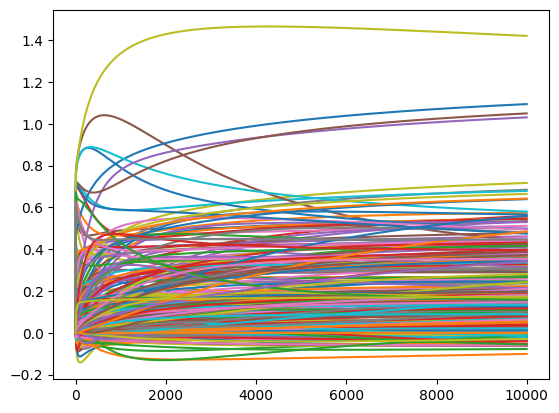

In [ ]:
import matplotlib.pyplot as plt

plt.plot(glm.theta_progress)

In [ ]:
glm.theta_progress[1]

array([ 4.00493656e-03,  8.38262788e-03,  1.34953258e-03, -5.91805044e-03,
        2.88593186e-04, -7.19197579e-04,  1.68380987e-02,  4.20424600e-04,
        1.21288125e-02,  1.18170583e-02,  9.27658559e-03,  1.41417525e-02,
        1.68734678e-03,  1.01646546e-02,  5.16413015e-03,  6.20936997e-03,
        7.03632372e-03,  4.43335341e-03,  1.27818396e-03, -2.56237853e-04,
        4.05958550e-03,  1.31326690e-02,  9.70693593e-03,  1.26921260e-02,
        3.97646387e-03, -1.26798994e-03,  1.53219099e-02,  4.79499642e-03,
       -9.66184046e-05,  1.27102393e-02,  6.38283237e-03,  5.25470017e-03,
       -2.50960276e-03,  1.36106380e-02,  1.16653114e-02,  2.47683274e-03,
        1.04172700e-02,  1.12332618e-02,  1.03662787e-02,  1.40673384e-02,
        1.37035904e-02,  7.49934295e-03,  7.37110399e-03,  6.30089546e-03,
        6.82801270e-03,  9.60575887e-03, -4.01289678e-03,  1.06697361e-03,
        2.26510574e-03,  1.50556509e-04,  1.50556509e-04, -1.10650283e-03,
       -2.69400100e-04,  

#### Testing

GLM RMSE on Training set : 0.08261224904299017
GLM RMSE on Test set : 0.0831800638961987


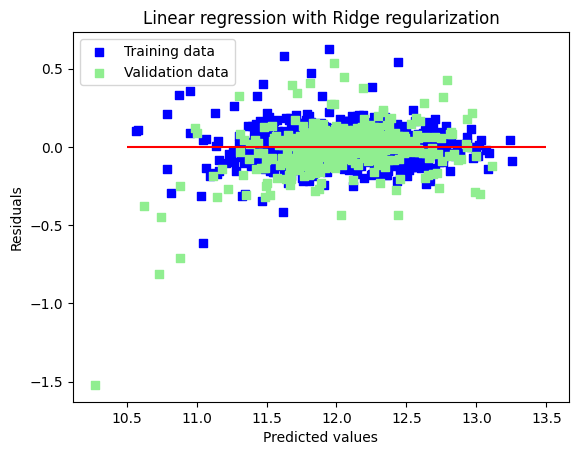

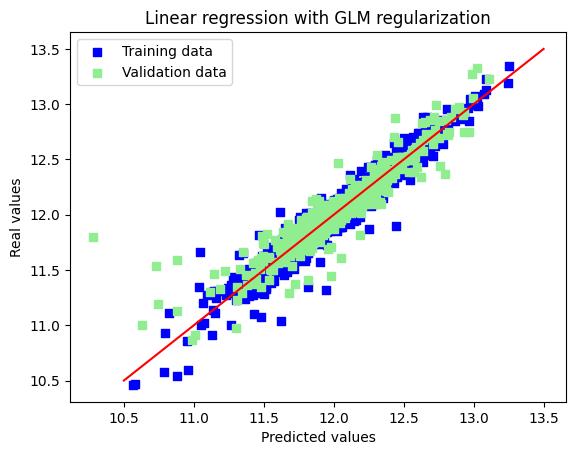

GLM Regression picked 315 features and eliminated the other 4 features


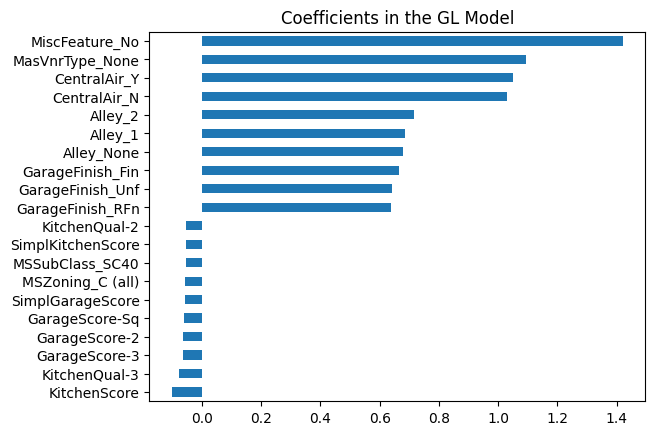

In [ ]:
predicted_y_glm_test = glm.predict(X_test)
predicted_y_glm_train = glm.predict(X_train)
error_glm_test = rmse(predicted_y_glm_test, y_test)
error_glm_train = rmse(predicted_y_glm_train, y_train)
print("GLM RMSE on Training set :", error_glm_train)
print("GLM RMSE on Test set :", error_glm_test)

# Plot residuals
plt.scatter(predicted_y_glm_train, predicted_y_glm_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_glm_test, predicted_y_glm_test - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(predicted_y_glm_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_glm_test, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with GLM regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(glm.theta, index = X_train.columns)
print("GLM Regression picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)] )
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the GL Model")
plt.show()

### Lasso

Implementamos nuestra propia version de Lasso y desarrolamos un modelo predictivo en funcion a esta

In [ ]:
class LassoRegression:
    def __init__(self, hypothesis, alpha = 1, step_size=0.00005, max_iter=100000, eps=1e-10,theta_0=None, verbose=True):
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.hypothesis = hypothesis
        self.alpha = alpha
        self.theta_progress = []
        self.losses = []

    def fit(self, x, y):
        iternumber = 0
        if self.theta is None:
          self.theta = np.zeros(x.shape[1])

        while iternumber < self.max_iter:
            iternumber += 1

            predicted_probabilities = self.predict(x)

            error = predicted_probabilities -y

            gradient = np.dot(x.transpose(),error)

            if self.verbose and iternumber % 1000 == 0:
                print(str(iternumber)+' '+str(np.sum(np.abs(error))))

            theta_old = self.theta
            self.theta_progress.append(self.theta)

            self.losses.append(np.sum(error))
            self.theta = self.theta - self.step_size * gradient

            self.theta = np.around(self.theta,5)

            if (abs(self.theta-theta_old) < self.eps).all():
                break

        return self.theta

    def predict(self, x):
      return self.hypothesis(x,self.theta)

#### Training

In [ ]:
lasso_reg = LassoRegression(model,step_size=0.0005, alpha=0.001,max_iter=10000)
thetas = lasso_reg.fit(X_train,y_train)

1000 0.0
2000 0.0
3000 0.0
4000 0.0
5000 0.0
6000 0.0


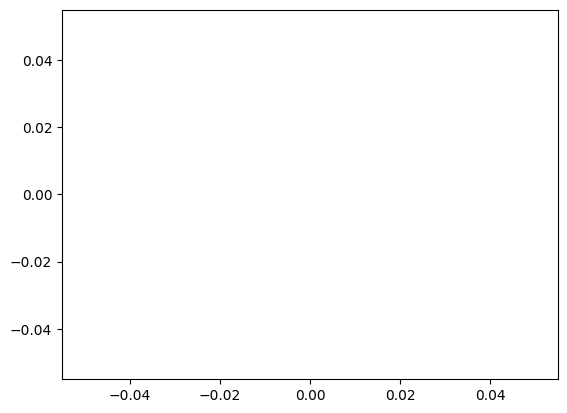

In [ ]:
plt.plot(np.array(lasso_reg.losses)[5000:])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.plot(lasso_reg.theta_progress[:,5])
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 1500x1500 with 0 Axes>

#### Testing

Lasso RMSE on Training set : 0.08318342055736365
Lasso RMSE on Test set : 0.08348632424219715


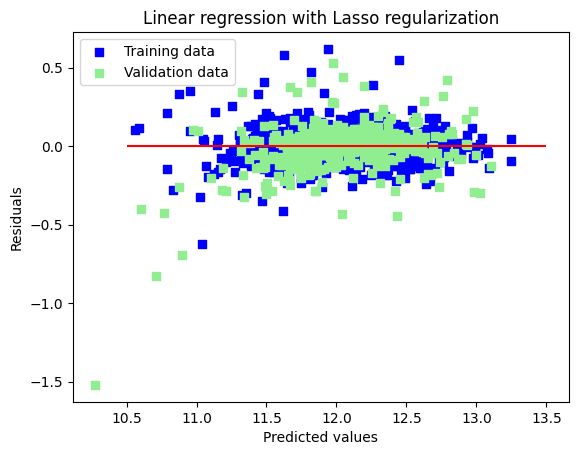

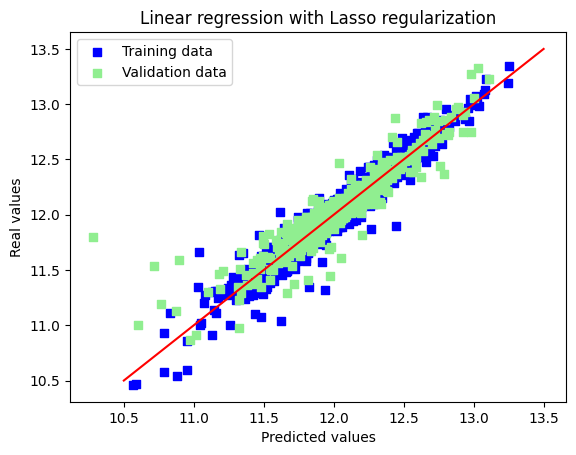

Lasso picked 315 features and eliminated the other 4 features


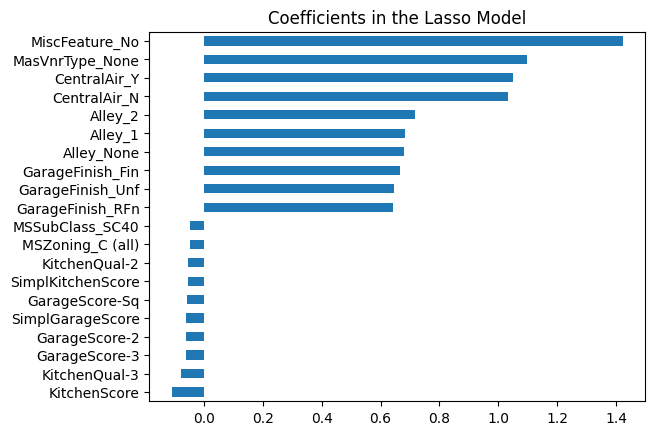

In [ ]:

predicted_y_lasso_test = lasso_reg.predict(X_test)
predicted_y_lasso_train = lasso_reg.predict(X_train)
error_lasso_test = rmse(predicted_y_lasso_test, y_test)
error_lasso_train = rmse(predicted_y_lasso_train, y_train)
print("Lasso RMSE on Training set :", error_lasso_train)
print("Lasso RMSE on Test set :", error_lasso_test)

# Plot residuals
plt.scatter(predicted_y_lasso_train, predicted_y_lasso_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_lasso_test, predicted_y_lasso_test - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(predicted_y_lasso_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_lasso_test, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs_lasso = pd.Series(lasso_reg.theta, index = X_train.columns)
print("Lasso picked " + str(sum(coefs_lasso != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_lasso == 0)) + " features")
imp_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10),
                     coefs_lasso.sort_values().tail(10)])
imp_coefs_lasso.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

En comparacion con la regresion lineal sin regularizacion no parece haber cambiado mucho: los coeficientes mas y menos importantes se mantienen (no necesariamente en orden, pero la features mas pesadas son muy parecidas).

### Ridge


In [ ]:
class RidgeRegression:
    def __init__(self, hypothesis, alpha = 1, step_size=0.00005, max_iter=100000, eps=1e-10,theta_0=None, verbose=True):
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.hypothesis = hypothesis
        self.alpha = alpha

    def fit(self, x, y):
        iternumber = 0
        if self.theta is None:
          self.theta = np.zeros(x.shape[1])

        while iternumber < self.max_iter:
            iternumber += 1

            predicted_probabilities = self.predict(x)

            error = predicted_probabilities -y

            gradient = np.dot(x.transpose(),error)

            if self.verbose:
                print(str(iternumber)+' '+str(np.sum(error)))

            theta_old = self.theta
            self.theta = self.theta - self.step_size * gradient
            if (abs(self.theta-theta_old) < self.eps).all():
                break

        return self.theta

    def predict(self, x):
      return self.hypothesis(x,self.theta)

Al igual que para Lasso, el mejor alpha de los que fueron probados fue 0.0001, asi que lo volveremos a usar

#### Training

In [ ]:
ridge_reg = RidgeRegression(model,step_size=0.00005, alpha=0.0001)
ridge_reg.fit(X_train,y_train)

#### Testing

In [ ]:
predicted_y_ridge_test = ridge_reg.predict(X_test)
predicted_y_ridge_train = ridge_reg.predict(X_train)
error_ridge_test = rmse(predicted_y_ridge_test, y_test)
error_ridge_train = rmse(predicted_y_ridge_train, y_train)
print("Ridge RMSE on Training set :", error_ridge_train)
print("Ridge RMSE on Test set :", error_ridge_test)

# Plot residuals
plt.scatter(predicted_y_ridge_train, predicted_y_ridge_train - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_ridge_test, predicted_y_ridge_test - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(predicted_y_ridge_train, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(predicted_y_ridge_test, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge_reg.theta, index = X_train.columns)
print("Ridge Regression picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### Elastic Net

In [ ]:
class ElasticNetRegression:
    def __init__(self, hypothesis, alpha = 5, beta = 0.2 , step_size=0.00005, max_iter=100000, eps=1e-10,theta_0=None, verbose=True):
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.hypothesis = hypothesis
        self.alpha = alpha
        self.beta = beta
        self.theta_progress = []
        self.losses = []

    def fit(self, x, y):
        iternumber = 0
        if self.theta is None:
          self.theta = np.zeros(x.shape[1])

        while iternumber < self.max_iter:
            iternumber += 1

            predicted_probabilities = self.predict(x)

            error = predicted_probabilities -y

            gradient = np.dot(x.transpose(),error)
            if self.verbose and iternumber % 1 == 0:
                print(str(iternumber)+' '+str(np.sum(error)))

            theta_old = self.theta

            self.theta_progress.append(self.theta)

            self.losses.append(np.sum(error))

            self.theta = self.theta - self.step_size * gradient

            if (abs(self.theta-theta_old) < self.eps).all():
                break

        return self.theta

    def predict(self, x):
      return self.hypothesis(x,self.theta)

    def coefs(self):
      return self.theta

#### Training

In [ ]:
en_reg = ElasticNetRegression(model,step_size=0.00003, alpha=0.0001, beta = 0.5,max_iter=100000)
thetas = en_reg.fit(X_train,y_train)

In [ ]:
plt.plot(np.array(en_reg.losses)[5000:])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.plot(np.array(en_reg.theta_progress)[:,120:125])
plt.show()

#### Testing


In [ ]:
y_train_ela = en_reg.predict(X_train)
y_test_ela = en_reg.predict(X_test)
error_en_test = rmse(y_test_ela, y_test)
error_en_train = rmse(y_train_ela, y_train)
print("Elastic Net RMSE on Training set :", error_en_train)
print("Elastic Net RMSE on Test set :", error_en_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(en_reg.coefs(), index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

## Comparacion con sklearn

En esta seccion queremos comparar nuestros resultados y tratar de entender las diferencias en nuestros resultados y los de SciKitLearn, una libreria que tiene ya los algoritmos implementados en los puntos anteriores.

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

### Ridge

In [ ]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)
error_ridge_test = rmse(ridge.predict(X_test), y_test)
error_ridge_train = rmse(ridge.predict(X_train), y_train)
print("Ridge RMSE on Training set :", error_en_train)
print("Ridge RMSE on Test set :", error_en_test)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85,
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

error_en_test = rmse(ridge.predict(X_test), y_test)
error_en_train = rmse(ridge.predict(X_train), y_train)
print("Linear RMSE on Training set :", error_en_train)
print("Linear RMSE on Test set :", error_en_test)
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Podemos ver que nuestra version de Ridge levanta features diferentes pero la cantidad de features es parecida y la capacidad de prediccion es solo un poco mejor que la nuestra.

### Lasso

In [ ]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                          0.3, 0.6, 1],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05,
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35,
                          alpha * 1.4],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)
error_las_test = rmse(y_test_las, y_test)
error_las_train = rmse(y_train_las, y_train)
print("Ridge RMSE on Training set :", error_las_train)
print("Ridge RMSE on Test set :", error_las_test)


# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

Esta version de Lasso es muy agresiva: elimina mas de la mitad de las features. Con esto genera una prediccion muy buena, no necesariamente mucho mejor que la nuestra, pero es buena.

Lo raro de nuestra version de Lasso es que elimina solo 4 features, que es muy poco. Entendemos que no hay ningun error en la programacion del algoritmo.

Se nos ocurre que el problema puede ser el siguiente: todos estos algoritmos pueden plantearse en su forma _closed form_ que permite descubrir sin ninguna iteracion los valores optimos de theta. Tal vez nuestro algoritmo eventualmente tiende a esta version, pero requiere mas iteraciones.

Si hacemos la comparacion nuestra version no es mala, la diferencia de la capacidad predictiva es muy chica.

### ElasticNet

In [ ]:
model = lambda x,theta: np.dot(x,theta)
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train,y_train)

y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

error_ela_test = rmse(y_test_ela, y_test)
error_ela_train = rmse(y_train_ela, y_train)
print("Ridge RMSE on Training set :", error_ela_train)
print("Ridge RMSE on Test set :", error_ela_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

Algo similar a lo que nos paso con Lasso sucede con ElasticNet: es un poco menos agresivo (porque combina la regularizacion L2 con la "dureza" de la  L1) pero elimina muchisimas features. Suponemos que lo que sucede es lo que ya explicamos para Lasso, aunque es raro.